In [1]:
# Part 3 ‐ Predictive modeling

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 2. Load the Dataset
df = pd.read_json("ultimate_data_challenge.json")
df.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


###  Dataset Overview

The dataset contains user-level information for those who signed up in **January 2014**, including:

- **Trips and Ratings**: `trips_in_first_30_days`, `avg_rating_of_driver`
- **Usage Patterns**: `avg_surge`, `surge_pct`, `weekday_pct`, `avg_dist`
- **Dates**: `signup_date`, `last_trip_date`
- **Device Info**: `phone` (iPhone or Android)
- **User Tags**: `ultimate_black_user`
- **Geography**: `city` (e.g., King's Landing, Astapor)

This data will be used to analyze and predict user retention.


In [5]:
# 3. Data Cleaning & Feature Engineering

# Convert date columns to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Create 'retained' column: 1 if last_trip_date is within 30 days of max date
max_date = df['last_trip_date'].max()
df['retained'] = df['last_trip_date'] >= (max_date - pd.Timedelta(days=30))
df['retained'] = df['retained'].astype(int)

# Check null values
df.isnull().sum()

# Impute missing ratings with mean (or median)

df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())


Retention rate: 37.61%


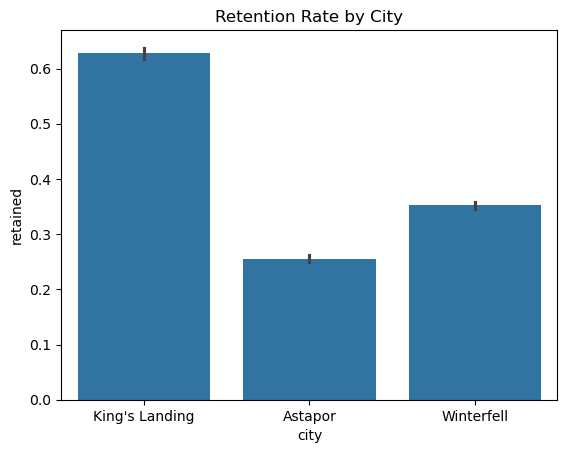

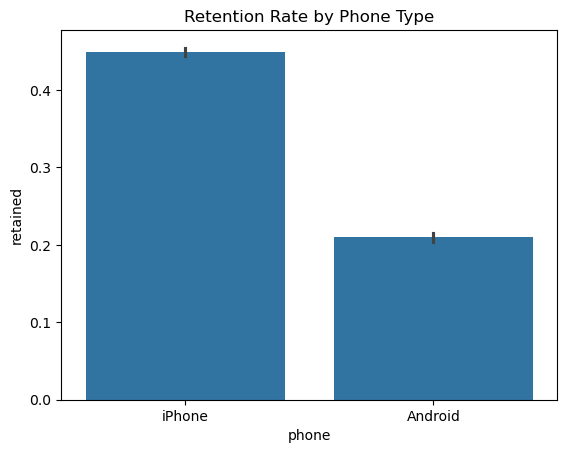

In [7]:
# 4. Exploratory Data Analysis (EDA)
# Retention rate
retention_rate = df['retained'].mean()
print(f"Retention rate: {retention_rate:.2%}")

# Plot: Retention by city
sns.barplot(x='city', y='retained', data=df)
plt.title('Retention Rate by City')
plt.show()

# Plot: Retention by phone type
sns.barplot(x='phone', y='retained', data=df)
plt.title('Retention Rate by Phone Type')
plt.show()


Retention Analysis
Overall Retention Rate
37.61% of users were retained (i.e., took a trip in the 30 days prior to the data cutoff).

Retention Rate by City
King’s Landing shows the highest retention rate.

Astapor has the lowest retention rate.

Winterfell is in between.

This suggests geographic differences influence user behavior.

Retention Rate by Phone Type
iPhone users are significantly more likely to be retained compared to Android users.

This could indicate differences in user engagement or app experience across platforms.



In [9]:
# 5. Prepare Features for Modeling

# One-hot encode categorical variables
df_model = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

# Drop columns not useful for prediction
df_model.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

# Features and Target
X = df_model.drop('retained', axis=1)
y = df_model['retained']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [11]:
# 6. Train Predictive Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


[[7575 1804]
 [1938 3683]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      9379
           1       0.67      0.66      0.66      5621

    accuracy                           0.75     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.75      0.75      0.75     15000

ROC AUC Score: 0.8158144904607053


Predictive Modeling
Modeling Steps
Model Used: Random Forest Classifier (100 trees, random_state=42)

Train-Test Split: 70% training, 30% testing

Features: One-hot encoded categorical variables (city, phone), dropped date columns.
The model performs reasonably well with balanced precision and recall.

ROC AUC of 0.82 indicates good discrimination between retained vs. non-retained users.


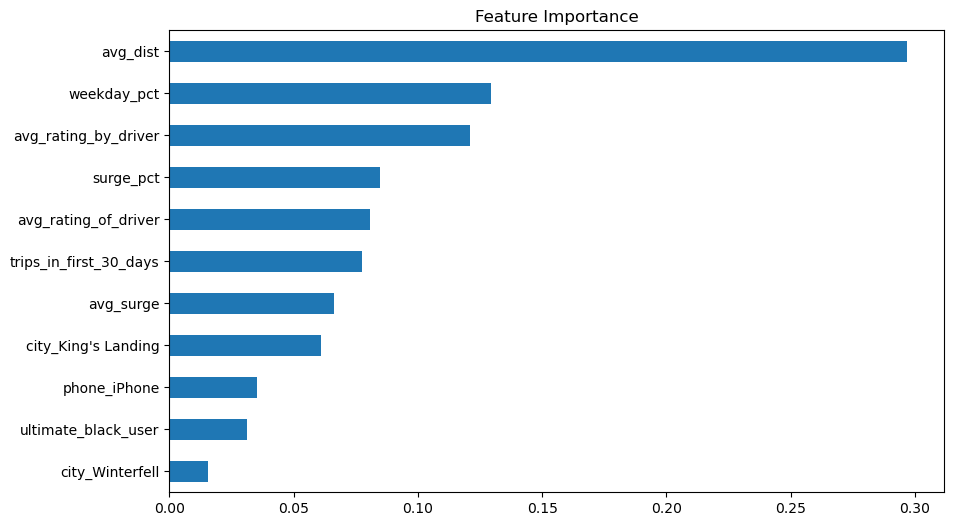

In [13]:
# 7. Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10,6))
plt.title("Feature Importance")
plt.show()


Feature Importance:

The Random Forest model identified the most influential features for predicting user retention:

Top Predictors:

avg_dist: Higher average distance per trip strongly correlates with retention.

weekday_pct: Weekday activity is a strong signal of continued usage.

avg_rating_by_driver: Reflects user behavior and satisfaction.

surge_pct: Indicates exposure to dynamic pricing, possibly suggesting higher engagement.

Less Impactful Features:

User's phone type (phone_iphone)

City-based features (e.g., city_Winterfell, city_King's Landing)

ultimate_black_user: Least important in this model.

These insights can help prioritize user targeting strategies and feature enhancements.

# 8. Business Insights 
### Insights and Recommendations

- Key predictors of retention include:
  - **Number of trips in first 30 days**
  - **Weekday trip %**
  - **Average distance**
  - **Ultimate Black usage**

- Drivers with early engagement (multiple trips) are more likely to stay.

### Suggestions for Ultimate:

- Offer promotions or bonuses to encourage more trips in the **first 30 days**.
- Target users with **low early engagement** for retention campaigns.
- Encourage weekday usage and explore differences in city-specific retention.



Summary & Conclusion

Goal: Predict whether a user will be retained (i.e., take a trip) within 6 months of signup.

Retention Rate: Approximately 37.6% of users were retained.

Model Used: Random Forest Classifier

Accuracy: 75%

ROC AUC Score: 0.82

Key Predictive Features:

avg_dist (average distance per trip)

weekday_pct (percentage of weekday rides)

avg_rating_by_driver

Insights:

Users who take longer trips or ride more frequently during weekdays are more likely to stay active.

Higher driver ratings for users may indicate smoother experiences and better retention.

Recommendation: Focus retention strategies on users with low weekday_pct or shorter average trip distances — they may need targeted incentives to stay engaged.